In [1]:
from gaussian_probability_path import GaussianConditionalProbabilityPath, LinearAlpha, LinearBeta
from mnist_sampler import MNISTSampler
from CFGTrainer import CFGTrainer
from simulator_utils import CFGVectorFieldODE, EulerSimulator

from dit import MNISTDiT
from unet import MNISTUNet
from mamba import MNISTMamba

import torch
from matplotlib import pyplot as plt
from torchvision.utils import make_grid

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/home/azureuser/mnist_flow_matching_v2/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Initialize probability path
# this is used to add noise to the images to train our diffusion model
path = GaussianConditionalProbabilityPath(
    p_data = MNISTSampler(),
    p_simple_shape = [1, 32, 32],
    alpha = LinearAlpha(),
    beta = LinearBeta()
).to(device)

In [3]:
# Initialize models
unet = MNISTUNet(
    channels = [32, 64, 128],
    num_residual_layers = 2,
    t_embed_dim = 40,
    y_embed_dim = 40,
)

dit = MNISTDiT(
    img_size=32,
    patch_size=4,  # 32/4 = 8, so 8x8 = 64 patches
    hidden_dim=384,  # Model dimension
    depth=6,  # Number of transformer blocks
    num_heads=6,  # Number of attention heads
    t_embed_dim=384,
    y_embed_dim=384
)

mamba = MNISTMamba(
    img_size=32,
    patch_size=4,
    d_model=256,  # Model dimension
    d_state=16,  # SSM state dimension
    depth=6,  # Number of Mamba blocks
    expand_factor=2,  # Inner dimension expansion
    t_embed_dim=256,
    y_embed_dim=256,
)

models = [unet, dit, mamba]

In [4]:
def print_params(model, name: str = "Model"):
    """Print number of parameters in a model"""
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"{name}: {total:,} params ({trainable:,} trainable)")

print_params(unet, "UNet")
print_params(dit, "DiT")
print_params(mamba, "Mamba")

UNet: 1,233,325 params (1,233,325 trainable)
DiT: 16,888,528 params (16,888,528 trainable)
Mamba: 4,233,360 params (4,233,360 trainable)


In [5]:
losses = []
for model in models:
    # Initialize trainer
    trainer = CFGTrainer(path = path, model = model, eta=0.1)
    
    # Train!
    trainer.train(num_epochs = 5000, device=device, lr=1e-3, batch_size=250)

    losses.append(trainer.losses)

Training model with size: 4.715 MiB


Epoch 4999, loss: 128.392: : 5000it [05:30, 15.15it/s]


Training model with size: 64.425 MiB


Epoch 4999, loss: 116.635: : 5000it [05:49, 14.30it/s]


Training model with size: 16.149 MiB


Epoch 4999, loss: 149.288: : 5000it [04:47, 17.38it/s]


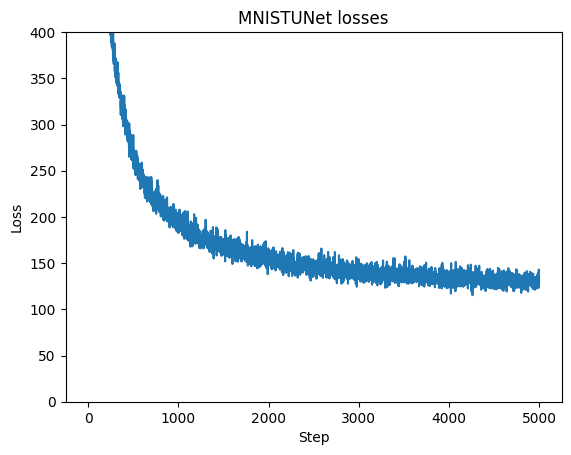

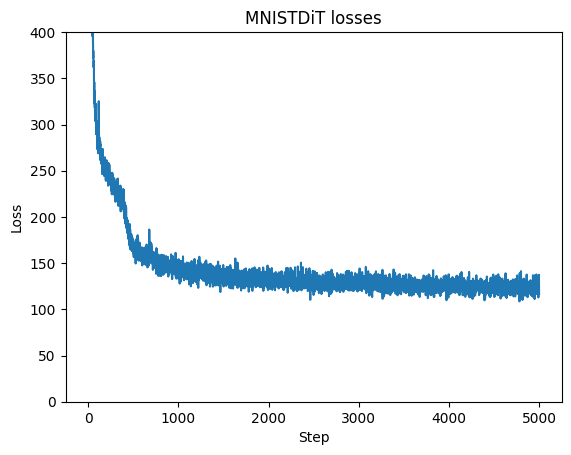

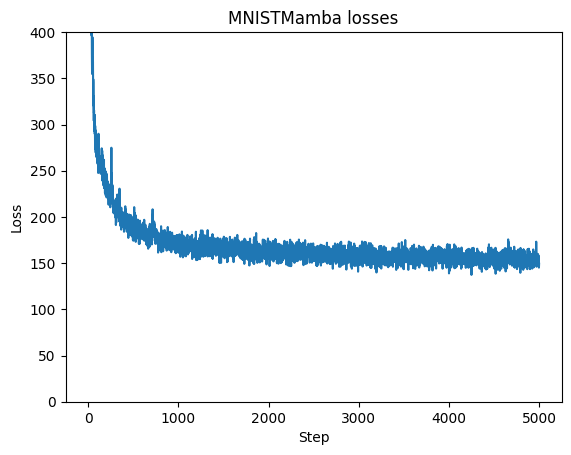

In [12]:
# Plot each run
for run_losses, model in zip(losses, models):
    plt.figure()
    plt.plot(run_losses, label=f"{type(model).__name__}")
    plt.title(f"{type(model).__name__} losses")
    plt.ylim(0,400)
    plt.xlabel("Step")
    plt.ylabel("Loss")
    plt.show()

In [7]:
# Play with these!
samples_per_class = 10
num_timesteps = 100
guidance_scales = [1.0, 3.0, 5.0]

def generate_samples(model):
    # Graph
    fig, axes = plt.subplots(1, len(guidance_scales), figsize=(10 * len(guidance_scales), 10))
    for idx, w in enumerate(guidance_scales):
        # Setup ode and simulator
        ode = CFGVectorFieldODE(model, guidance_scale=w)
        simulator = EulerSimulator(ode)
    
        # Sample initial conditions
        y = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], dtype=torch.int64).repeat_interleave(samples_per_class).to(device)
        num_samples = y.shape[0]
        x0, _ = path.p_simple.sample(num_samples) # (num_samples, 1, 32, 32)
    
        # Simulate
        ts = torch.linspace(0,1,num_timesteps).view(1, -1, 1, 1, 1).expand(num_samples, -1, 1, 1, 1).to(device)
        x1 = simulator.simulate(x0, ts, y=y)
        
        # Plot
        grid = make_grid(x1, nrow=samples_per_class, normalize=True, value_range=(-1,1))
        axes[idx].imshow(grid.permute(1, 2, 0).cpu(), cmap="gray")
        axes[idx].axis("off")
        axes[idx].set_title(f"Guidance: $w={w:.1f}$ ({type(model).__name__})", fontsize=25)
            
    plt.show()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:01<00:00, 66.76it/s]


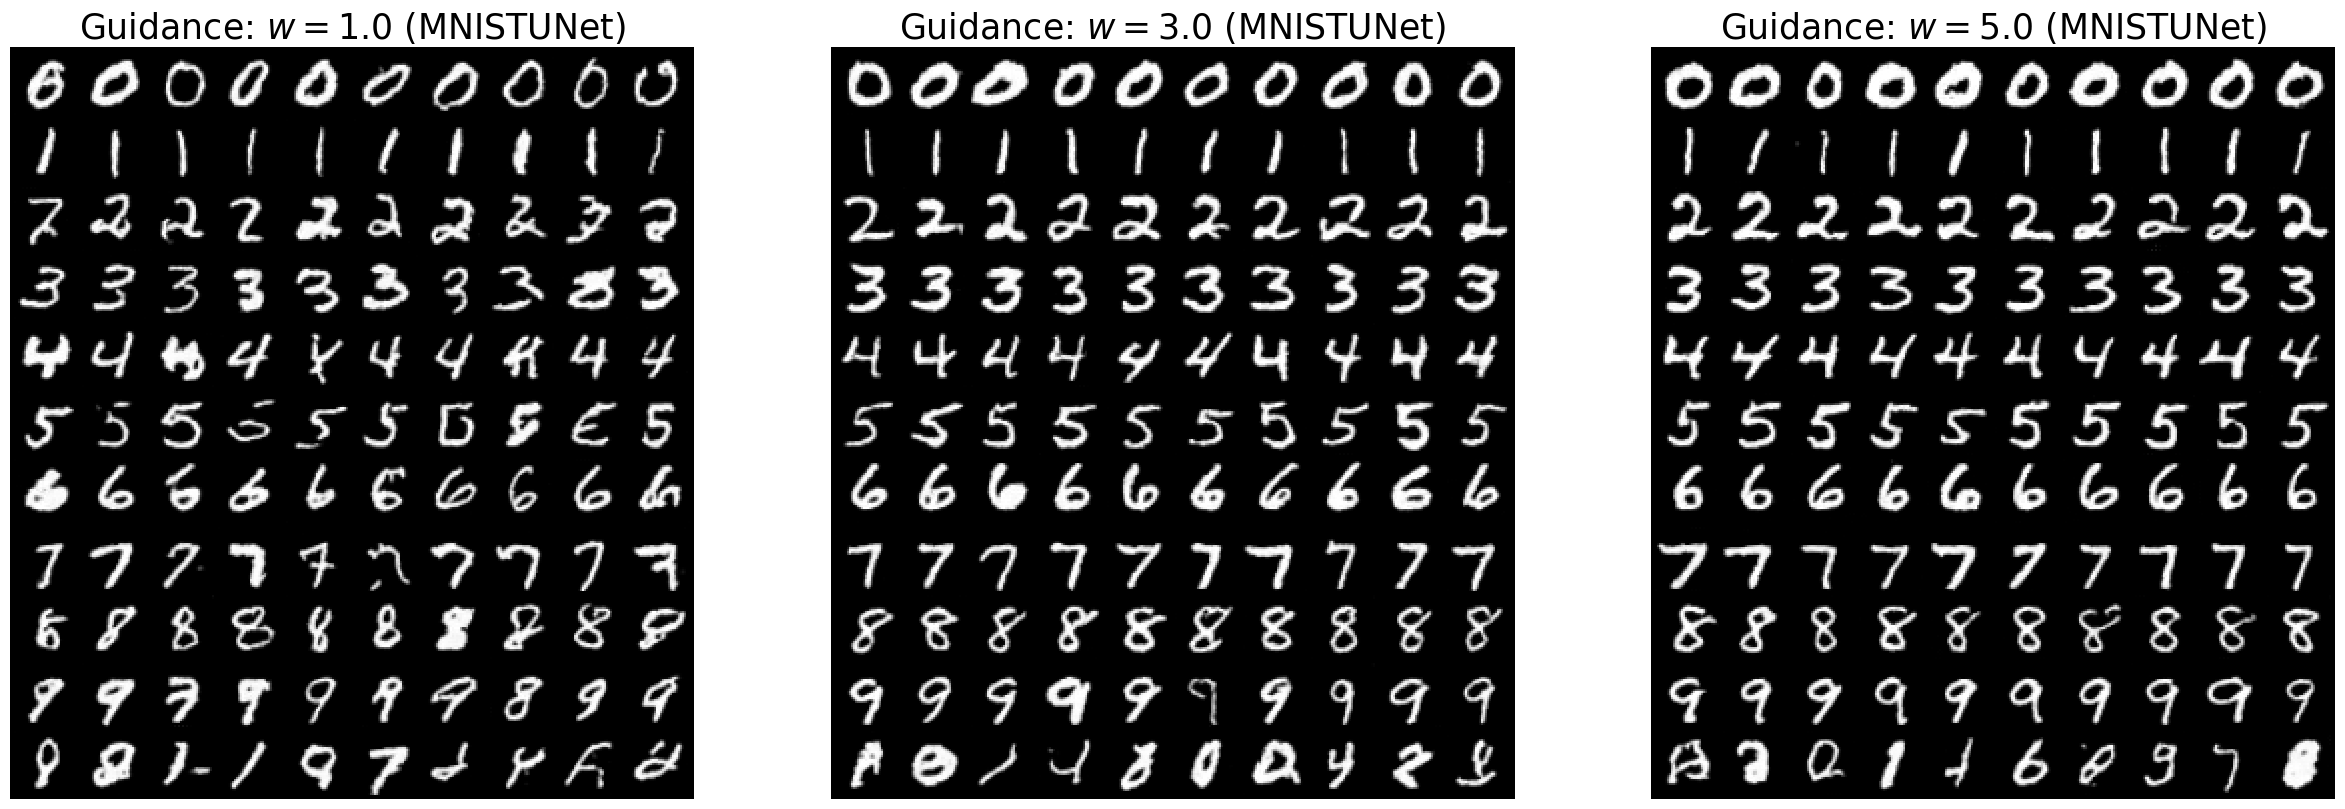

In [8]:
generate_samples(unet)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:01<00:00, 70.35it/s]


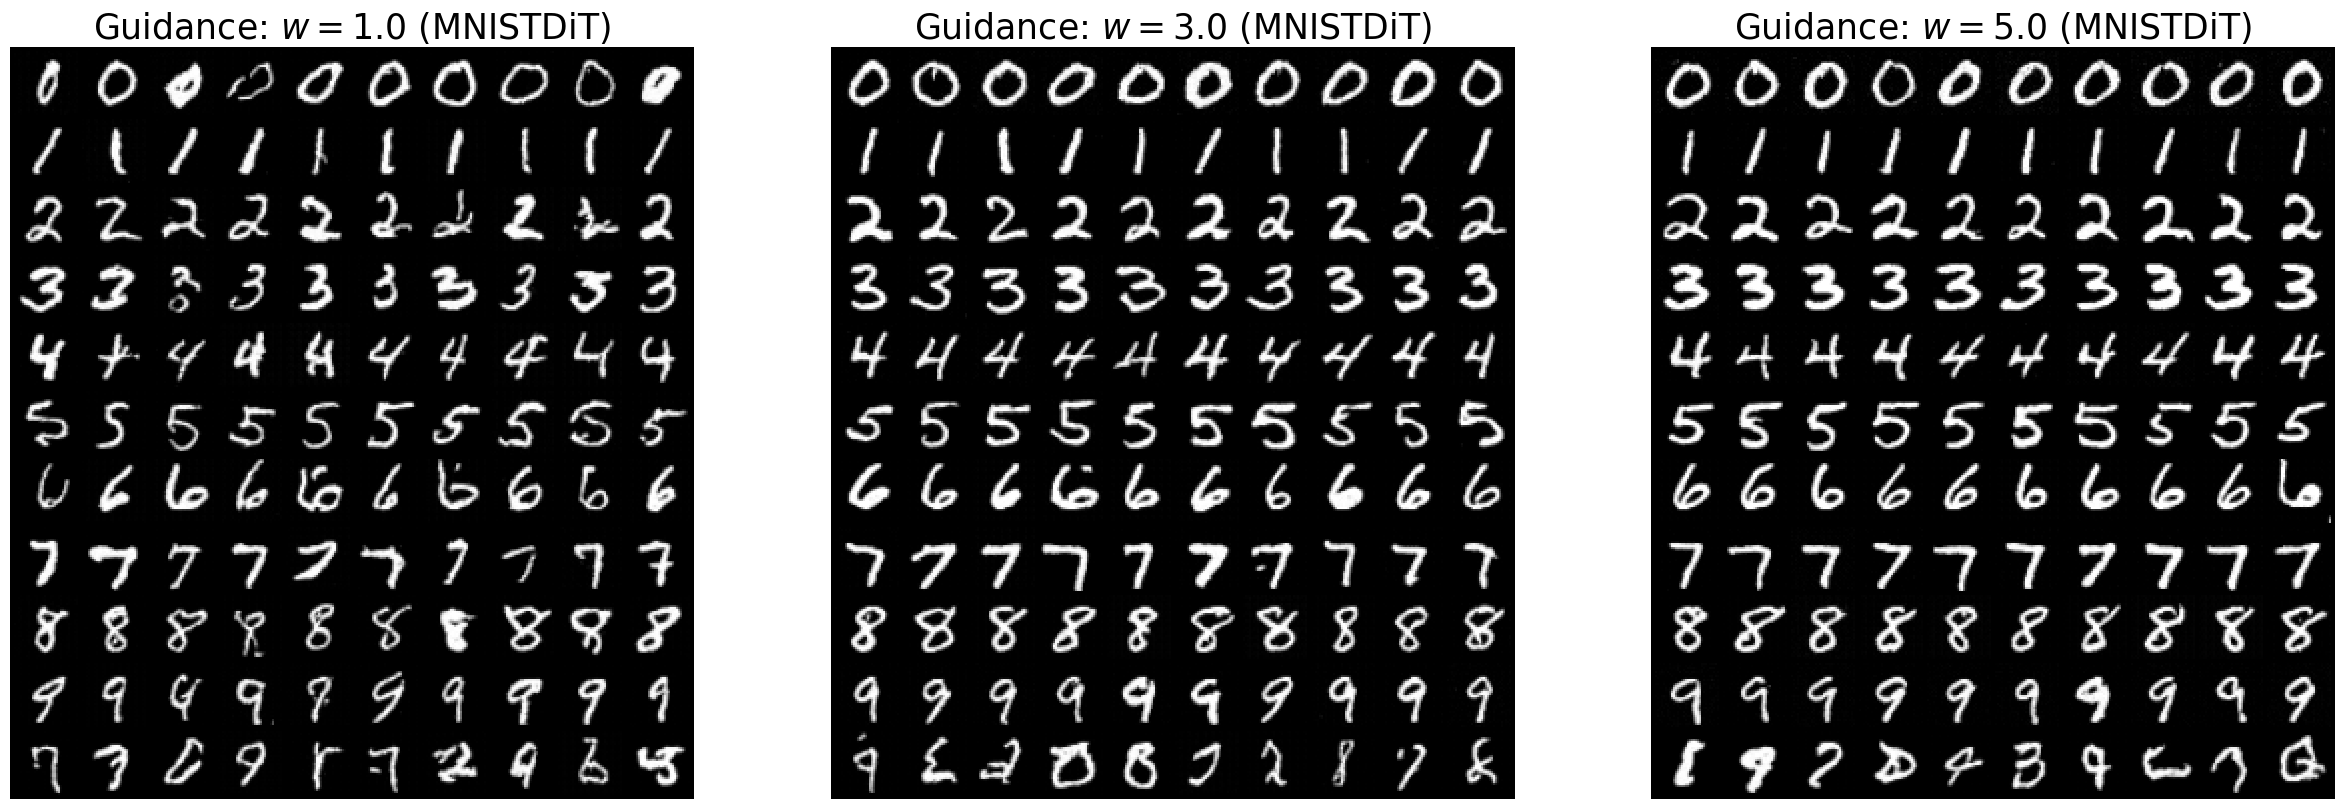

In [9]:
generate_samples(dit)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 113.24it/s]


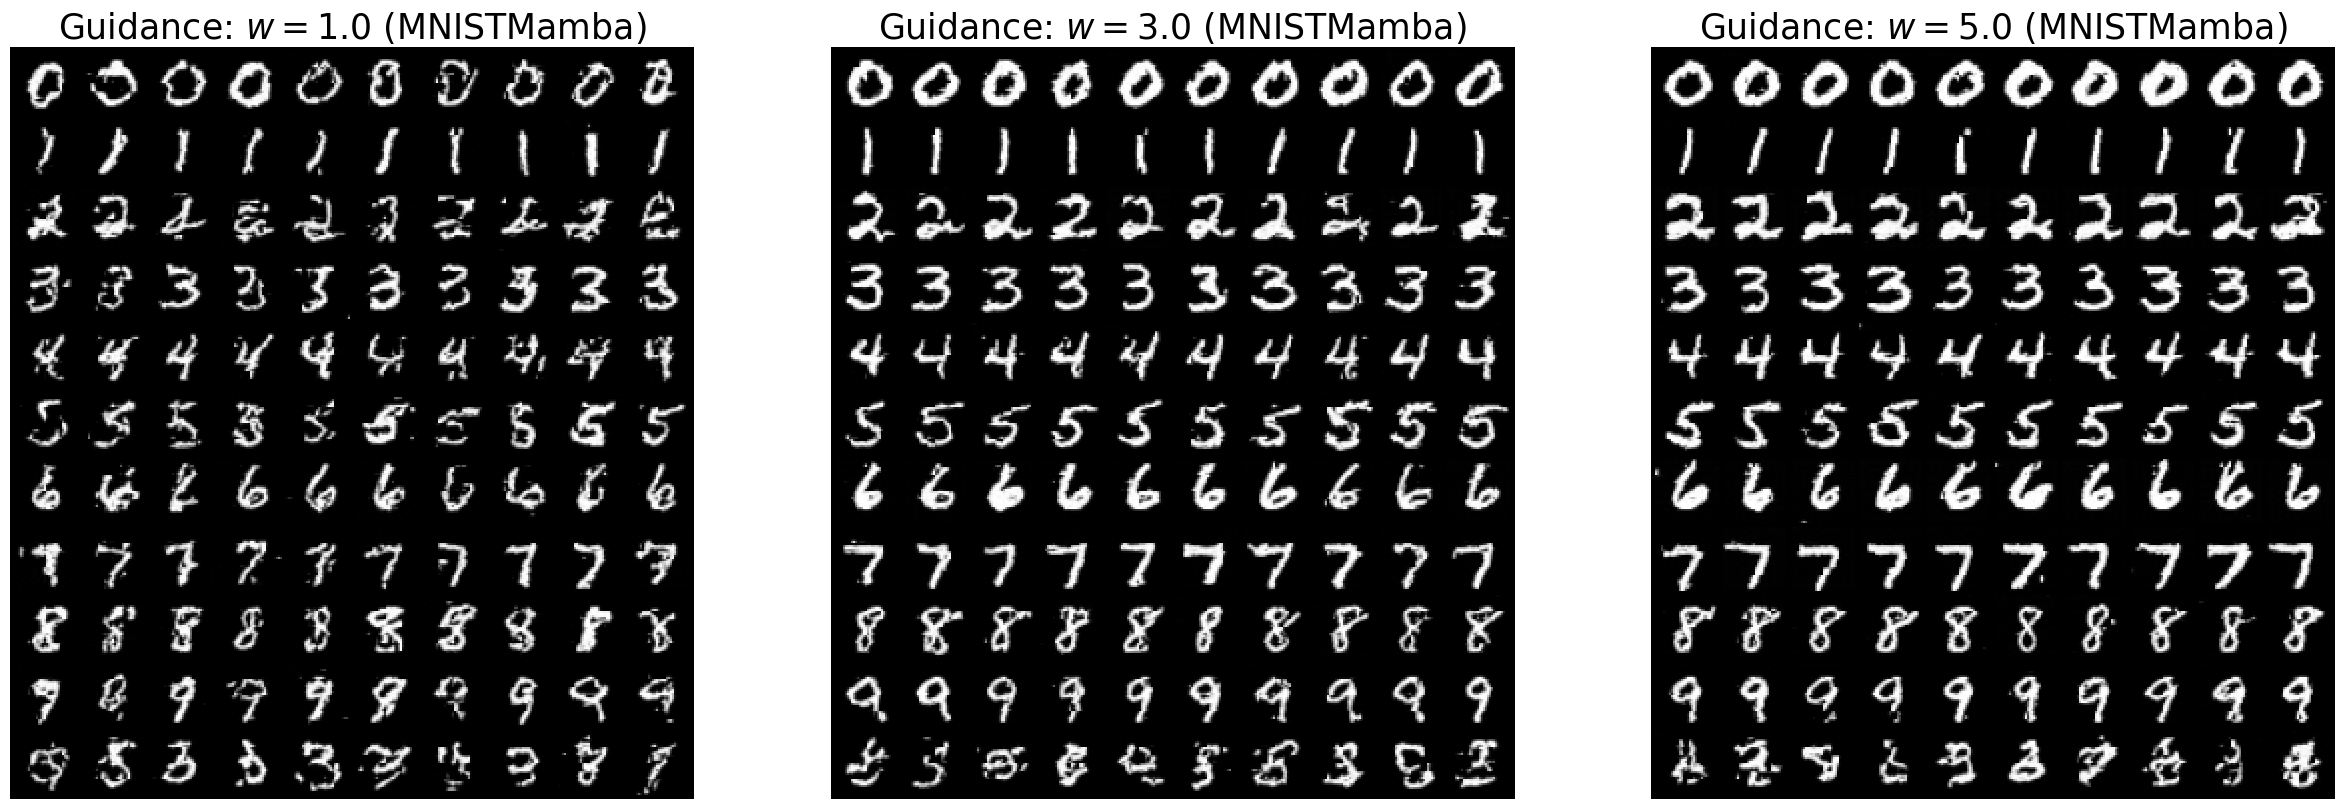

In [10]:
generate_samples(mamba)

In [29]:
import statistics
agg_idx = -500
print(statistics.mean(losses[0][agg_idx:]))
print(statistics.mean(losses[1][agg_idx:]))
print(statistics.mean(losses[2][agg_idx:]))

131.15216737365722
123.9374905090332
154.31495816040038
